In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


The goal of this project is to understand the impact of an aging population on labor force participation rates. In particular,
I am concerned with answering the question "What would the aggregate labor force participation rate of people age 15 and older 
be in 2015, if the age distribution of the population were the same as it was in 1995?"

I have survey data from 1995 and 2015. Note some individuals are over or underrepresented in this sample, so sample weights
must be applied in order to produce representative statistics. 

Below, I've included a key explaining how this data has been labeled:

 AGE		<br/>
1995: 90+ coded as 90    <br/>
2015: 80-84 coded as 80, 85+ coded as 85   <br/>

 SEX	
1		Male   <br/>
2		Female   <br/>
9		Not in universe   <br/>

 POPSTAT	(Adult civilian, armed forces, or child)   <br/>
1		Adult civilian   <br/>
2		Armed forces   <br/>
3		Child (14 or younger)  <br/>

 LABFORCE	(Labor force status)   <br/>
0		Not in universe   <br/>
1		No, not in the labor force   <br/>
2		Yes, in the labor force   <br/>

 WTSUPP		(Supplement Weight)   <br/>
 
This data was provided to me by the Penn Wharton Budget Model as part of a research project I completed for them.


In [2]:
#Import the data 
data = pd.read_csv('MarchCPS_1995_2015.csv')
data.head()

,year,wtsupp,age,sex,popstat,labforce
0,1995,929.61,48,2,1,1
1,1995,832.67,65,2,1,2
2,1995,787.95,10,2,3,0
3,1995,938.27,25,2,1,2
4,1995,900.74,21,1,1,2


In [3]:
#Restrict our analysis to the universe of individuals who are included in labor force participation statistics
universe = data[data['popstat']==1].copy()

#Now for some data cleaning and preparation

#Adjust labforce variable such that 0 corresponds to not participating and 1 corresponds to participating (since everyone
#is now in-universe)
universe['labforce'] -= 1

#Since some ages greater than 80 are coded as 80, I will censor all the data such that 80 is the maximum age value. 
#This is to easily facilitate apples to apples comparisons within and between years. Given the rarity of such individuals
#in the data set, I do not expect this to be a significant source of bias- though accounting for a censored independent variable
#might be an interesting econometric problem, it is a bit beyond my current scope.
universe['age'] = universe['age'].apply(lambda x: min(x,80))

#Create an "age squared" stat
universe['agesq'] = universe['age']*universe['age']

universe.head()

,year,wtsupp,age,sex,popstat,labforce,agesq
0,1995,929.61,48,2,1,0,2304
1,1995,832.67,65,2,1,1,4225
3,1995,938.27,25,2,1,1,625
4,1995,900.74,21,1,1,1,441
5,1995,864.86,36,1,1,1,1296


In [4]:
#Apply survey weights to the labforce variable so that we can compare overall labor force participation rates between years

#Find average weight for each year
averageweight_1995 = universe[universe['year']==1995]['wtsupp'].mean()
averageweight_2015 = universe[universe['year']==2015]['wtsupp'].mean()

#Apply weights to 1995 data
uni_1995 = universe[universe['year']==1995].copy()
uni_1995['w_labforce'] = uni_1995['labforce']*uni_1995['wtsupp']/averageweight_1995

#Apply weights to 2015 data
uni_2015=universe[universe['year']==2015].copy()
uni_2015['w_labforce'] = uni_2015['labforce']*uni_2015['wtsupp']/averageweight_2015

#Recombine 1995 and 2015 data sets
universe = pd.concat([uni_1995, uni_2015], join="inner").reset_index(drop=True)
universe.head()


,year,wtsupp,age,sex,popstat,labforce,agesq,w_labforce
0,1995,929.61,48,2,1,0,2304,0.000000
1,1995,832.67,65,2,1,1,4225,0.469670
2,1995,938.27,25,2,1,1,625,0.529234
3,1995,900.74,21,1,1,1,441,0.508065
4,1995,864.86,36,1,1,1,1296,0.487827


In [5]:
#Let's look at how the overall labor force participation rates (LFPR) vary between 1995 and 2015
universe[['year','w_labforce']].groupby('year').mean()

,w_labforce
year,
1995,0.651931
2015,0.616368


We see that 2015 had a noticeably lower labor force participation rate than 1995. Can we explain this in terms of an aging population?

Text(0.5, 1.0, 'Labor Force Participation Rate by Age, 1995')

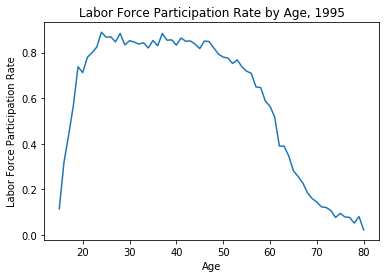

In [6]:
#Let's see how labor force participation rates vary by age in both 1995 and 2015. 
lfpr_vs_age_1995 = uni_1995[['age','w_labforce']].groupby('age').mean()

plt.plot(lfpr_vs_age_1995['w_labforce'])
plt.xlabel('Age')
plt.ylabel('Labor Force Participation Rate')
plt.title('Labor Force Participation Rate by Age, 1995')

Text(0.5, 1.0, 'Labor Force Participation Rate by Age, 2015')

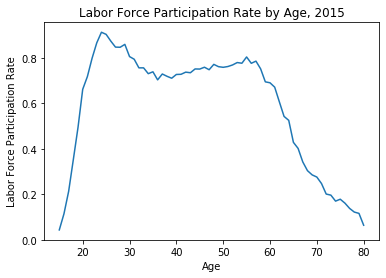

In [7]:
#Repeat this analysis for 2015
lfpr_vs_age_2015 = uni_2015[['age','w_labforce']].groupby('age').mean()

plt.plot(lfpr_vs_age_2015['w_labforce'])
plt.xlabel('Age')
plt.ylabel('Labor Force Participation Rate')
plt.title('Labor Force Participation Rate by Age, 2015')

In 2015, there is a downward convexity in the labor force participation rates that starts with those in their early 20's and
bottoms out with those in their early to mid 30's. This convexity is not present in 1995, which obeys the expected pattern of LFPR steadily increasing until 25 or so, plateauing, then beginning to decrease as individuals reach retirement.

This strongly suggests that any overall difference in labor force participation rates between 1995 and 2015 cannot be explained
solely in terms of an aging population. 

Next, I will use 1995 data to build a logistic model that predicts labor force participation rates as a function of age. Then I will use this model to predict the 2015 aggregate labor force participation rate given the age structure of the 2015 population. Any residual difference between the observed 2015 LFPR and the model-predicted 2015 LFPR is attributable to non-aging factors. 

In [8]:
x_vars = uni_1995[['age','agesq']].copy()
y_vars = uni_1995['labforce'].copy()
weights = uni_1995['wtsupp'].copy()

In [9]:
logreg = LogisticRegression()
model = logreg.fit(x_vars, y_vars, sample_weight=weights)

C:\Users\nkreu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
model.coef_

array([[ 0.30044385, -0.00381478]])

In [11]:
model.intercept_

array([-4.02957117])

In [12]:
#Our model takes the form y=exp(0.30044385*age-0.00381478*agesq-4.02957117)/(1+exp(0.30044385*age-0.00381478*agesq-4.02957117))
#Note that this analysis was originally conducted in Stata and significant p-values were found at the 0.01 level for all 
#model parameters. Unfortunately, scikit-learn does not seem to have p-values supported and statsmodels does not seem to support
#sample weights. So I did this in scikit-learn. 

In [13]:
#Let's see how often our model makes the correct prediction in-sample
logreg.score(x_vars, y_vars)

0.7977175689209847

In [14]:
#And let's also look at how its mistakes break down by true classification
y_pred = logreg.predict(x_vars)
confusion_matrix = confusion_matrix(y_vars, y_pred)
print(confusion_matrix)

[[22658 17563]
 [ 5462 68143]]


It seems that the model almost always classifies labor force participators correctly and classifies those not in the labor force correctly around 55% of the time. 

In [15]:
#Let's attach a model-predicted probability to each observation in-sample.
def predict_lfp(age,agesq):
    y=math.exp(0.30044385*age-0.00381478*agesq-4.02957117)/(1+math.exp(0.30044385*age-0.00381478*agesq-4.02957117))
    return y
    

In [16]:
uni_1995['Model Predicted LFP Probability']=uni_1995.apply(lambda x: predict_lfp(x.age, x.agesq),axis=1)
uni_1995.head()

,year,wtsupp,age,sex,popstat,labforce,agesq,w_labforce,Model Predicted LFP Probability
0,1995,929.61,48,2,1,0,2304,0.000000,0.832365
1,1995,832.67,65,2,1,1,4225,0.469670,0.350199
3,1995,938.27,25,2,1,1,625,0.529234,0.749752
4,1995,900.74,21,1,1,1,441,0.508065,0.645069
5,1995,864.86,36,1,1,1,1296,0.487827,0.863239


In [17]:
uni_1995['Model Predicted LFP Probability'].mean()

0.6482075523204618

In [18]:
uni_1995[uni_1995['labforce']==0]['Model Predicted LFP Probability'].mean()

0.4437505260353371

In [19]:
uni_1995[uni_1995['labforce']==1]['Model Predicted LFP Probability'].mean()

0.7599318380920342

Overall, it looks like the model does a good job of predicting labor force participation in 1995. It predicts an aggregate LFPR very close to the true observed LFPR, reliably classifies those in the labor force correctly, and is more likely than not to correctly classify those not in the labor force as well. Now we will see what this model predicts for 2015.

In [20]:
uni_2015['Model Predicted LFP Probability']=uni_2015.apply(lambda x: predict_lfp(x.age, x.agesq),axis=1)
uni_2015.head()

,year,wtsupp,age,sex,popstat,labforce,agesq,w_labforce,Model Predicted LFP Probability
149642,2015,690.05,48,1,1,1,2304,0.415813,0.832365
149643,2015,690.05,45,2,1,0,2025,0.000000,0.853894
149644,2015,583.80,23,2,1,1,529,0.351789,0.703207
149646,2015,735.83,80,2,1,0,6400,0.000000,0.012025
149647,2015,513.98,64,2,1,1,4096,0.309716,0.394962


In [21]:
uni_2015['Model Predicted LFP Probability'].mean()

0.6346104529083473

The model-predicted aggregate LFPR for 2015 is 63.46%, which is 1.36 percentage points lower than the model-predicted aggregate LFPR for 1995. Therefore I attribute approximately ~1.36 percentage points of the LFPR decrease between 1995 and 2015 to population aging, leaving a gap of 2.20 percentage points that cannot be explained in this manner. 

This means that had the population not aged and all else remained constant, we should expect the LFPR in 2015 to have been around 63.00%. 